In [1]:
import pandas as pd
import numpy as np
import sklearn
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from mpl_toolkits.basemap import Basemap
sns.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# View all columns on the screen
pd.set_option('max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',1000)

In [3]:
query_string1 = '''
                select * from merged order by pickup_datetime asc
'''

In [4]:
# Connect to the existing fleetriskdb
con = sqlite3.connect('./DB/nyctaximergeddb.sqlite')
# Confirm data is being returned from this query
df = pd.read_sql_query(query_string1, con)
# Verify that result of SQL query is stored in the dataframe
df = df.drop('index', axis=1)
# Let's filter down to Rate codes 1, 2 and 3 - NYC and its surrounding airports.
taxidf = df.copy()
taxidf = taxidf[taxidf.rate_code < 4]
taxidf.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
14064063,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.981850,40.783993,-73.991020,40.770947,CSH,5.5,0.5,0.5,0.00,0.0,6.50
14064064,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.976997,40.761559,-74.003853,40.742271,CRD,14.5,0.5,0.5,2.00,0.0,17.50
14064065,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.979881,40.776081,-73.982071,40.768272,CRD,4.0,0.5,0.5,1.00,0.0,6.00
14064066,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.7,-73.942482,40.779572,-73.942482,40.779572,CRD,7.5,0.5,0.5,1.11,0.0,9.61
14064067,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-73.998215,40.729637,-73.992798,40.748791,CSH,7.5,0.5,0.5,0.00,0.0,8.50


In [5]:
# What is the average daily earnings of a taxi driver?

# Convert pickup_datetime and dropoff_datetime to datetime format
taxidf['pickup_datetime'] = pd.to_datetime(taxidf['pickup_datetime'])
taxidf['dropoff_datetime'] = pd.to_datetime(taxidf['dropoff_datetime'])

# Get the date alone
taxidf['date'] = taxidf.pickup_datetime.dt.date
taxidf.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,date
14064063,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.981850,40.783993,-73.991020,40.770947,CSH,5.5,0.5,0.5,0.00,0.0,6.50,2013-04-30
14064064,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.976997,40.761559,-74.003853,40.742271,CRD,14.5,0.5,0.5,2.00,0.0,17.50,2013-04-30
14064065,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.979881,40.776081,-73.982071,40.768272,CRD,4.0,0.5,0.5,1.00,0.0,6.00,2013-04-30
14064066,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.7,-73.942482,40.779572,-73.942482,40.779572,CRD,7.5,0.5,0.5,1.11,0.0,9.61,2013-04-30
14064067,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-73.998215,40.729637,-73.992798,40.748791,CSH,7.5,0.5,0.5,0.00,0.0,8.50,2013-04-30


In [51]:
# What is the average daily earnings of a taxi?
taxidf.groupby(['medallion', 'date'])['total_amount'].sum().mean()

479.87261688433625

In [52]:
# What is the average daily earnings of a taxi driver?
taxidf.groupby(['hack_license', 'date'])['total_amount'].sum().mean()

258.90833059665266

In [7]:
# What is the max daily earnings of a taxi driver?
taxidf.groupby(['medallion', 'date'])['total_amount'].sum().sort_values(ascending=False)

medallion                         date      
C767E6FAAE6A65D77701979221AE61CF  2013-04-17    5093.96
80D52C5885ECE494DE95F9B2E69DA7EF  2013-04-12    1288.53
8DEB70907D00AA1D7FF5E2683240549B  2013-04-19    1061.25
45886CDFD76DF25E0ACA5E3ED611C68E  2013-04-14    1056.87
C78F6ED99E72F27BD00EDDD768F9B61B  2013-04-20    1035.81
80D52C5885ECE494DE95F9B2E69DA7EF  2013-04-11    1020.85
5F2EFC03B544635C9B0E7A4AA4FF9AC3  2013-04-28    1020.23
75EE5A7E8B24FD2B2FB715955834C524  2013-04-06    1015.18
6C2FA93D2F3E5580B617EDEBFF33AD5A  2013-04-12    1011.39
FF40FB8123940D9F96D33EDA1D92A83C  2013-04-13    1004.83
C70EECB031BB649F5FB1AB95F00AC53A  2013-04-12    1004.24
19E063791B0DF5A558B8488180DDAB67  2013-04-14     998.97
986B763D0A245A998B865F6AC1A055CA  2013-04-20     997.91
44A8553C60763B082E348394F2E32464  2013-04-12     996.65
0C9C589C0AD57ECCB633CB90A33DC37A  2013-04-06     992.72
75EE5A7E8B24FD2B2FB715955834C524  2013-04-11     992.08
5F9C08A05F6449EE31F056AEB85855BB  2013-04-12     990.83
19E

In [8]:
# What is the min daily earnings of a taxi driver?
taxidf.groupby(['medallion', 'date'])['total_amount'].sum().min()

3.0

In [9]:
# 2 d.p. of precision on pickup longitude and latitude will suffice
taxidf2 = taxidf.copy()
taxidf2['pickup_latitude'] = taxidf2.pickup_latitude.round(2)
taxidf2['pickup_longitude'] = taxidf2.pickup_longitude.round(2)
taxidf2['dropoff_latitude'] = taxidf2.dropoff_latitude.round(2)
taxidf2['dropoff_longitude'] = taxidf2.dropoff_longitude.round(2)
taxidf2.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,date
14064063,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.98,40.78,-73.99,40.77,CSH,5.5,0.5,0.5,0.00,0.0,6.50,2013-04-30
14064064,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.98,40.76,-74.00,40.74,CRD,14.5,0.5,0.5,2.00,0.0,17.50,2013-04-30
14064065,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.98,40.78,-73.98,40.77,CRD,4.0,0.5,0.5,1.00,0.0,6.00,2013-04-30
14064066,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.7,-73.94,40.78,-73.94,40.78,CRD,7.5,0.5,0.5,1.11,0.0,9.61,2013-04-30
14064067,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-74.00,40.73,-73.99,40.75,CSH,7.5,0.5,0.5,0.00,0.0,8.50,2013-04-30


In [10]:
taxidf2['pickup_geocode'] = taxidf2.pickup_latitude.astype(str) + ', ' + taxidf2.pickup_longitude.astype(str)
taxidf2['dropoff_geocode'] = taxidf2.dropoff_latitude.astype(str) + ', ' + taxidf2.dropoff_longitude.astype(str)
taxidf2.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,date,pickup_geocode,dropoff_geocode
14064063,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.98,40.78,-73.99,40.77,CSH,5.5,0.5,0.5,0.00,0.0,6.50,2013-04-30,"40.78, -73.98","40.77, -73.99"
14064064,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.98,40.76,-74.00,40.74,CRD,14.5,0.5,0.5,2.00,0.0,17.50,2013-04-30,"40.76, -73.98","40.74, -74.0"
14064065,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.98,40.78,-73.98,40.77,CRD,4.0,0.5,0.5,1.00,0.0,6.00,2013-04-30,"40.78, -73.98","40.77, -73.98"
14064066,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.7,-73.94,40.78,-73.94,40.78,CRD,7.5,0.5,0.5,1.11,0.0,9.61,2013-04-30,"40.78, -73.94","40.78, -73.94"
14064067,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-74.00,40.73,-73.99,40.75,CSH,7.5,0.5,0.5,0.00,0.0,8.50,2013-04-30,"40.73, -74.0","40.75, -73.99"


In [11]:
# Creating trips with a combination of pickup and dropoff codes
taxidf3 = taxidf2.copy()
taxidf3['route'] = taxidf3.pickup_geocode + ' : ' + taxidf3.dropoff_geocode
# Filter down to routes with 385+ trips
#taxidf3 = taxidf2.groupby('route').filter(lambda x: len(x) >= 385)
# Check
#taxidf4.groupby('route').size().sort_values(ascending=True).head()
taxidf3.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,date,pickup_geocode,dropoff_geocode,route
14064063,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.98,40.78,-73.99,40.77,CSH,5.5,0.5,0.5,0.00,0.0,6.50,2013-04-30,"40.78, -73.98","40.77, -73.99","40.78, -73.98 : 40.77, -73.99"
14064064,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.98,40.76,-74.00,40.74,CRD,14.5,0.5,0.5,2.00,0.0,17.50,2013-04-30,"40.76, -73.98","40.74, -74.0","40.76, -73.98 : 40.74, -74.0"
14064065,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.98,40.78,-73.98,40.77,CRD,4.0,0.5,0.5,1.00,0.0,6.00,2013-04-30,"40.78, -73.98","40.77, -73.98","40.78, -73.98 : 40.77, -73.98"
14064066,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.7,-73.94,40.78,-73.94,40.78,CRD,7.5,0.5,0.5,1.11,0.0,9.61,2013-04-30,"40.78, -73.94","40.78, -73.94","40.78, -73.94 : 40.78, -73.94"
14064067,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-74.00,40.73,-73.99,40.75,CSH,7.5,0.5,0.5,0.00,0.0,8.50,2013-04-30,"40.73, -74.0","40.75, -73.99","40.73, -74.0 : 40.75, -73.99"


In [12]:
# Filter down to routes with 385+ trips
taxidf4 = taxidf3.groupby('route').filter(lambda x: len(x) >= 385)
taxidf4.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,date,pickup_geocode,dropoff_geocode,route
14064062,663B7A92F7677B4807449344FDD373ED,025C5D47809A6A21CF8B28FA760443E1,CMT,1,2013-04-30 23:59:57,2013-05-01 00:07:11,2,434,2.2,-73.98,40.77,-73.95,40.78,CSH,9.0,0.5,0.5,0.0,0.0,10.0,2013-04-30,"40.77, -73.98","40.78, -73.95","40.77, -73.98 : 40.78, -73.95"
14064063,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.98,40.78,-73.99,40.77,CSH,5.5,0.5,0.5,0.0,0.0,6.5,2013-04-30,"40.78, -73.98","40.77, -73.99","40.78, -73.98 : 40.77, -73.99"
14064064,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.98,40.76,-74.00,40.74,CRD,14.5,0.5,0.5,2.0,0.0,17.5,2013-04-30,"40.76, -73.98","40.74, -74.0","40.76, -73.98 : 40.74, -74.0"
14064065,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.98,40.78,-73.98,40.77,CRD,4.0,0.5,0.5,1.0,0.0,6.0,2013-04-30,"40.78, -73.98","40.77, -73.98","40.78, -73.98 : 40.77, -73.98"
14064067,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-74.00,40.73,-73.99,40.75,CSH,7.5,0.5,0.5,0.0,0.0,8.5,2013-04-30,"40.73, -74.0","40.75, -73.99","40.73, -74.0 : 40.75, -73.99"


In [13]:
# The same two routes generate the highest revenue
ordered = taxidf4.groupby(['route', 'date'])['total_amount'].agg({sum, len}).reset_index()
ordered.sort_values(['sum', 'len'], ascending=[False, False]).head(20)

,route,date,sum,len
43082,"40.75, -73.99 : 40.76, -73.98",2013-04-25,31601.93,2982.0
61558,"40.77, -73.87 : 40.76, -73.98",2013-04-22,30975.73,713.0
61561,"40.77, -73.87 : 40.76, -73.98",2013-04-25,30282.95,696.0
43060,"40.75, -73.99 : 40.76, -73.98",2013-04-03,30169.26,3197.0
61551,"40.77, -73.87 : 40.76, -73.98",2013-04-15,29878.51,664.0
43081,"40.75, -73.99 : 40.76, -73.98",2013-04-24,29122.84,2975.0
61545,"40.77, -73.87 : 40.76, -73.98",2013-04-09,28977.08,663.0
43080,"40.75, -73.99 : 40.76, -73.98",2013-04-23,28908.36,3031.0
43069,"40.75, -73.99 : 40.76, -73.98",2013-04-12,28859.43,3076.0
43061,"40.75, -73.99 : 40.76, -73.98",2013-04-04,28673.53,2994.0


In [14]:
# Heres a list of the routes that generate the highest revenue along with the number of trips per route in April 2013
ordered2 = taxidf4.groupby(['route'])['total_amount'].agg({sum, len}).reset_index()
ordered2.sort_values(['sum', 'len'], ascending=[False, False]).head(10)

,route,sum,len
1436,"40.75, -73.99 : 40.76, -73.98",722612.28,78839.0
2052,"40.77, -73.87 : 40.76, -73.98",668457.45,15424.0
1685,"40.76, -73.97 : 40.75, -73.99",590744.80,50610.0
1774,"40.76, -73.98 : 40.75, -73.99",587081.65,65963.0
2189,"40.77, -73.96 : 40.76, -73.97",558885.32,66224.0
1684,"40.76, -73.97 : 40.75, -73.98",545272.15,64337.0
1435,"40.75, -73.99 : 40.76, -73.97",525268.60,44467.0
1426,"40.75, -73.99 : 40.75, -73.98",522044.20,61683.0
1345,"40.75, -73.98 : 40.76, -73.97",521643.72,62088.0
1704,"40.76, -73.97 : 40.77, -73.96",518156.80,67073.0


In [18]:
# What route generates the highest revenue per hour?
taxidf5 = taxidf4.copy()
taxidf5['trip_time_in_hours'] = 1.0*taxidf5['trip_time_in_secs']/3600
taxidf5['earnings_per_hour'] = 1.0*taxidf5['total_amount']/taxidf5['trip_time_in_hours']
taxidf5.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,date,pickup_geocode,dropoff_geocode,route,trip_time_in_hours,earnings_per_hour
14064062,663B7A92F7677B4807449344FDD373ED,025C5D47809A6A21CF8B28FA760443E1,CMT,1,2013-04-30 23:59:57,2013-05-01 00:07:11,2,434,2.2,-73.98,40.77,-73.95,40.78,CSH,9.0,0.5,0.5,0.0,0.0,10.0,2013-04-30,"40.77, -73.98","40.78, -73.95","40.77, -73.98 : 40.78, -73.95",0.120556,82.949309
14064063,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.98,40.78,-73.99,40.77,CSH,5.5,0.5,0.5,0.0,0.0,6.5,2013-04-30,"40.78, -73.98","40.77, -73.99","40.78, -73.98 : 40.77, -73.99",0.060833,106.849315
14064064,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.98,40.76,-74.00,40.74,CRD,14.5,0.5,0.5,2.0,0.0,17.5,2013-04-30,"40.76, -73.98","40.74, -74.0","40.76, -73.98 : 40.74, -74.0",0.279444,62.624254
14064065,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.98,40.78,-73.98,40.77,CRD,4.0,0.5,0.5,1.0,0.0,6.0,2013-04-30,"40.78, -73.98","40.77, -73.98","40.78, -73.98 : 40.77, -73.98",0.048056,124.855491
14064067,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-74.00,40.73,-73.99,40.75,CSH,7.5,0.5,0.5,0.0,0.0,8.5,2013-04-30,"40.73, -74.0","40.75, -73.99","40.73, -74.0 : 40.75, -73.99",0.121667,69.863014


In [20]:
# Let's look at the average earnings per hour across routes and focus on those whose average is the highest
taxidf5.groupby(['route'])['earnings_per_hour'].mean().sort_values(ascending=False).head(10)

route
40.77, -73.86 : 40.77, -73.86    902.529947
40.73, -73.95 : 40.73, -73.95    682.860162
40.82, -73.95 : 40.82, -73.95    366.392074
40.77, -73.87 : 40.77, -73.87    358.273602
40.78, -73.99 : 40.78, -73.99    353.083296
40.68, -74.0 : 40.68, -74.0      346.811199
40.82, -73.96 : 40.82, -73.96    341.175722
40.77, -73.99 : 40.77, -73.99    317.922676
40.7, -74.01 : 40.7, -74.01      298.385789
40.75, -73.94 : 40.75, -73.94    296.814561
Name: earnings_per_hour, dtype: float64

These trips all start and end in the same geocodes, so it is the shorter trips that maximize revenues.

In [21]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

In [22]:
# Trip
start_loc = geolocator.reverse("40.77, -73.86")
print start_loc.address

D5, Delta Departures, East Elmhurst, Queens County, NYC, New York, 11368, United States of America


In [24]:
start_loc = geolocator.reverse("40.73, -73.95")
print start_loc.address

226, Newel Street, Greenpoint, Kings County, NYC, New York, 11222, United States of America


In [25]:
start_loc = geolocator.reverse("40.82, -73.95")
print start_loc.address

North Academic Center, Convent Avenue, Hamilton Heights, Manhattan Community Board 9, New York County, NYC, New York, 10031, United States of America


In [26]:
start_loc = geolocator.reverse("40.77, -73.87")
print start_loc.address

Aloft New York LaGuardia Airport, 100-15, Ditmars Boulevard, North Beach, Queens County, NYC, New York, 11369, United States of America


In [27]:
start_loc = geolocator.reverse("40.78, -73.99")
print start_loc.address

Pier I, Upper West Side, Manhattan Community Board 7, New York County, NYC, New York, 10036, United States of America


In [29]:
taxidf6 = taxidf5.copy()
taxidf6['earnings_per_mi'] = 1.0*taxidf6['total_amount']/taxidf6['trip_distance']
taxidf6.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,date,pickup_geocode,dropoff_geocode,route,trip_time_in_hours,earnings_per_hour,earnings_per_mi
14064062,663B7A92F7677B4807449344FDD373ED,025C5D47809A6A21CF8B28FA760443E1,CMT,1,2013-04-30 23:59:57,2013-05-01 00:07:11,2,434,2.2,-73.98,40.77,-73.95,40.78,CSH,9.0,0.5,0.5,0.0,0.0,10.0,2013-04-30,"40.77, -73.98","40.78, -73.95","40.77, -73.98 : 40.78, -73.95",0.120556,82.949309,4.545455
14064063,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.98,40.78,-73.99,40.77,CSH,5.5,0.5,0.5,0.0,0.0,6.5,2013-04-30,"40.78, -73.98","40.77, -73.99","40.78, -73.98 : 40.77, -73.99",0.060833,106.849315,6.500000
14064064,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.98,40.76,-74.00,40.74,CRD,14.5,0.5,0.5,2.0,0.0,17.5,2013-04-30,"40.76, -73.98","40.74, -74.0","40.76, -73.98 : 40.74, -74.0",0.279444,62.624254,4.166667
14064065,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.98,40.78,-73.98,40.77,CRD,4.0,0.5,0.5,1.0,0.0,6.0,2013-04-30,"40.78, -73.98","40.77, -73.98","40.78, -73.98 : 40.77, -73.98",0.048056,124.855491,10.000000
14064067,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-74.00,40.73,-73.99,40.75,CSH,7.5,0.5,0.5,0.0,0.0,8.5,2013-04-30,"40.73, -74.0","40.75, -73.99","40.73, -74.0 : 40.75, -73.99",0.121667,69.863014,5.000000


In [30]:
# Let's look at the average earnings per hour across routes and focus on those whose average is the highest
taxidf6.groupby(['route'])['earnings_per_mi'].mean().sort_values(ascending=False).head(10)

route
40.77, -73.86 : 40.77, -73.86    28.688650
40.68, -74.0 : 40.68, -74.0      23.036364
40.76, -73.93 : 40.76, -73.93    21.512929
40.78, -73.99 : 40.78, -73.99    21.389261
40.7, -74.01 : 40.7, -74.01      19.290227
40.74, -74.01 : 40.74, -74.01    19.054555
40.81, -73.94 : 40.81, -73.94    18.955432
40.77, -73.87 : 40.77, -73.87    18.543298
40.68, -73.98 : 40.68, -73.98    18.364141
40.72, -74.0 : 40.72, -74.0      17.585208
Name: earnings_per_mi, dtype: float64

In [45]:
# What if we want to determine which routes generate the most revenue with the fewest trips?
# These are the trips that generate highest revenue while being the least crowded
ordered3 = ordered2.copy()
ordered3['rev_per_trip'] = ordered3.iloc[:,1]/ordered3.iloc[:,2]
ordered3.sort_values('rev_per_trip').tail(10)

,route,sum,len,rev_per_trip
265,"40.71, -74.01 : 40.77, -73.86",84121.55,1681.0,50.042564
131,"40.7, -74.01 : 40.77, -73.86",22200.63,439.0,50.570911
308,"40.71, -74.02 : 40.77, -73.87",49291.81,964.0,51.132583
1963,"40.77, -73.86 : 40.71, -74.01",120456.64,2352.0,51.214558
2020,"40.77, -73.87 : 40.71, -74.02",63822.04,1236.0,51.635955
307,"40.71, -74.02 : 40.77, -73.86",26108.49,499.0,52.321623
2082,"40.77, -73.89 : 40.71, -74.01",35217.20,668.0,52.720359
1962,"40.77, -73.86 : 40.7, -74.01",37488.95,708.0,52.950494
2028,"40.77, -73.87 : 40.72, -74.02",21711.32,410.0,52.954439
1964,"40.77, -73.86 : 40.71, -74.02",34186.93,640.0,53.417078


In [46]:
taxidf6['DayofWeek'] = taxidf6.pickup_datetime.dt.weekday_name
taxidf6['Hour'] = taxidf6.pickup_datetime.dt.hour
taxidf6.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,date,pickup_geocode,dropoff_geocode,route,trip_time_in_hours,earnings_per_hour,earnings_per_mi,DayofWeek,Hour
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.99,40.75,-73.96,40.77,CRD,12.0,0.5,0.5,2.6,0.0,15.6,2013-04-01,"40.75, -73.99","40.77, -73.96","40.75, -73.99 : 40.77, -73.96",0.175556,88.860759,4.588235,Monday,0
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.96,40.72,-73.97,40.71,CRD,5.0,0.5,0.5,1.1,0.0,7.1,2013-04-01,"40.72, -73.96","40.71, -73.97","40.72, -73.96 : 40.71, -73.97",0.066667,106.500000,7.319588,Monday,0
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.99,40.76,-74.00,40.74,CRD,7.5,0.5,0.5,2.0,0.0,10.5,2013-04-01,"40.76, -73.99","40.74, -74.0","40.76, -73.99 : 40.74, -74.0",0.100000,105.000000,6.213018,Monday,0
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.97,40.76,-73.98,40.74,CRD,7.0,0.5,0.5,1.5,0.0,9.5,2013-04-01,"40.76, -73.97","40.74, -73.98","40.76, -73.97 : 40.74, -73.98",0.083333,114.000000,5.219780,Monday,0
5,975EF587DDCAB5070B2C1C62309D86AD,71AFE02FC67FC11A8B4CE79805EA5CA0,VTS,1,2013-04-01,2013-04-01 00:08:00,1,480,1.81,-73.98,40.75,-73.99,40.76,CRD,8.0,0.5,0.5,1.0,0.0,10.0,2013-04-01,"40.75, -73.98","40.76, -73.99","40.75, -73.98 : 40.76, -73.99",0.133333,75.000000,5.524862,Monday,0


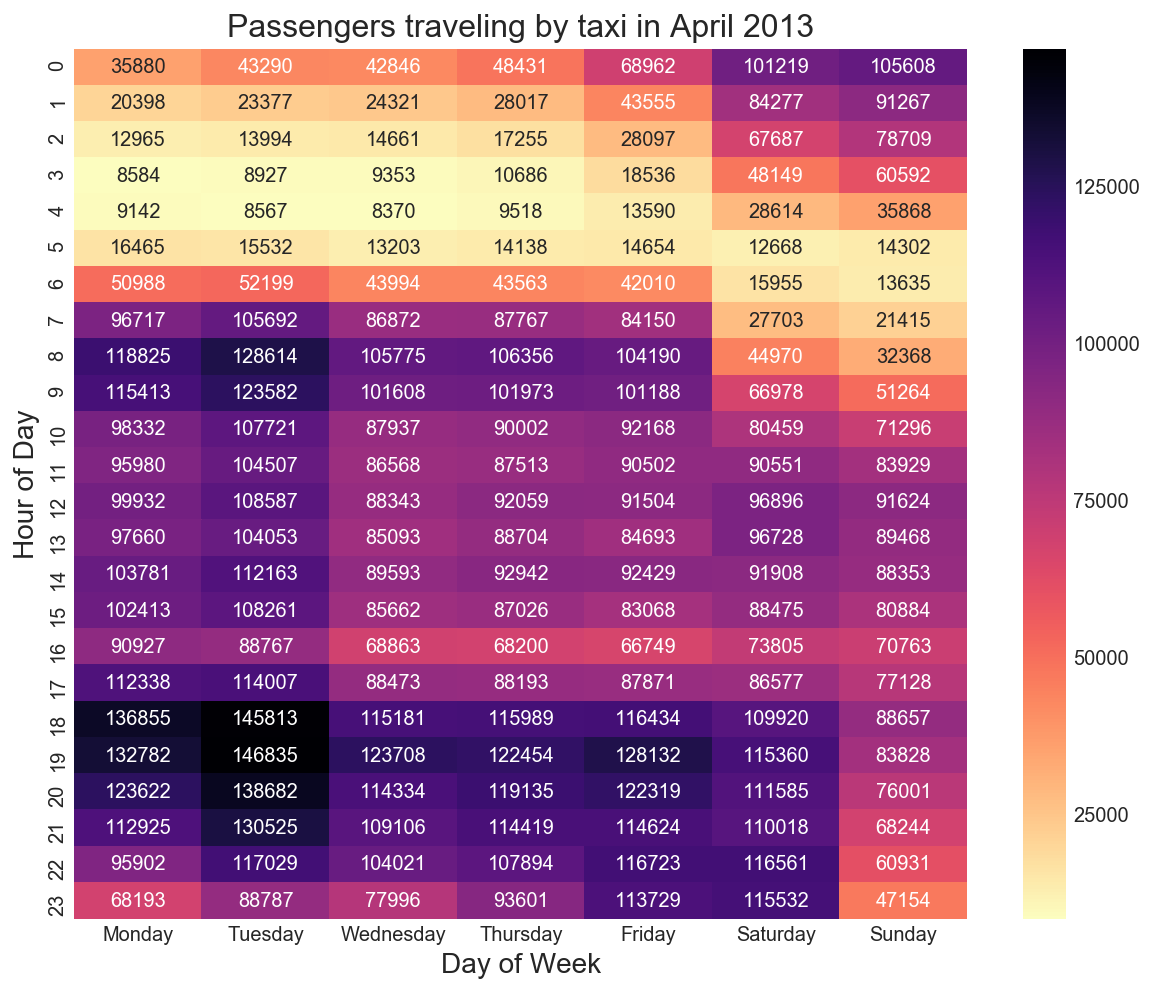

In [50]:
# What are the busiest days and hours for taxi drivers?
busiest_df = taxidf6.groupby(['DayofWeek','Hour'])['passenger_count'].size().reset_index()
busiest_piv = pd.pivot_table(busiest_df, values="passenger_count",index=["Hour"], columns=["DayofWeek"], fill_value=0)
busiest_piv = busiest_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
#plot pivot table as heatmap using seaborn
fig, ax = plt.subplots(figsize=(10,8))
#im = ax.imshow(busiest_piv, cmap="Greens")
#fig.colorbar(im, ax=ax)
ax = sns.heatmap(busiest_piv, ax=ax, cmap='magma_r', annot=True, fmt='g')
ax.set_xlabel('Day of Week', fontsize=14)
ax.set_ylabel('Hour of Day', fontsize=14)
ax.set_title('Passengers traveling by taxi in April 2013', fontsize=16)
None

### Evening Shift

In [53]:
evening_df = taxidf6.copy()
evening_df = evening_df[evening_df.Hour >= 16]
evening_df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,date,pickup_geocode,dropoff_geocode,route,trip_time_in_hours,earnings_per_hour,earnings_per_mi,DayofWeek,Hour
213650,C7376896E2CCE352A299472108E79900,C41892D3E7B42ACDE0C202A419A05D36,CMT,1,2013-04-01 16:00:00,2013-04-01 16:10:03,1,602,1.1,-73.99,40.75,-73.99,40.76,CRD,8.0,1.0,0.5,1.9,0.00,11.40,2013-04-01,"40.75, -73.99","40.76, -73.99","40.75, -73.99 : 40.76, -73.99",0.167222,68.172757,10.363636,Monday,16
213651,1803A06155B880D1027E09C12042C949,4229BFE37EE5FCAF69F8891EB38FDD48,CMT,1,2013-04-01 16:00:00,2013-04-01 16:18:21,1,1101,3.1,-73.97,40.76,-74.00,40.72,CRD,14.5,1.0,0.5,4.8,0.00,20.80,2013-04-01,"40.76, -73.97","40.72, -74.0","40.76, -73.97 : 40.72, -74.0",0.305833,68.010899,6.709677,Monday,16
213652,90227D00039EEFA93217DEC5A78CB5D3,F8D1F859F573158330CB14B55F08725B,CMT,1,2013-04-01 16:00:00,2013-04-01 16:03:00,1,167,0.6,-73.96,40.78,-73.95,40.79,CRD,4.0,1.0,0.5,1.0,0.00,6.50,2013-04-01,"40.78, -73.96","40.79, -73.95","40.78, -73.96 : 40.79, -73.95",0.046389,140.119760,10.833333,Monday,16
213653,923D00A5FB2BD13C91A588139FD1783D,A7D26239619F8D0A17700657D154DB98,CMT,1,2013-04-01 16:00:00,2013-04-01 16:05:00,1,313,0.8,-73.99,40.76,-73.97,40.76,CRD,5.5,1.0,0.5,1.0,0.00,8.00,2013-04-01,"40.76, -73.99","40.76, -73.97","40.76, -73.99 : 40.76, -73.97",0.086944,92.012780,10.000000,Monday,16
213654,57247FB98D9CC3E85B6DC19F9E1E7F42,96243CDED19B3243C8A8ED78EE2DA4B4,CMT,1,2013-04-01 16:00:00,2013-04-01 16:26:00,1,1546,10.8,-73.99,40.74,-73.87,40.77,CRD,32.0,1.0,0.5,4.0,5.33,42.83,2013-04-01,"40.74, -73.99","40.77, -73.87","40.74, -73.99 : 40.77, -73.87",0.429444,99.733506,3.965741,Monday,16


In [54]:
evening_df.groupby(['route'])['earnings_per_hour'].mean().sort_values(ascending=False).head(10)

route
40.77, -73.86 : 40.77, -73.86    1040.224859
40.82, -73.96 : 40.82, -73.96     602.320382
40.68, -74.0 : 40.68, -74.0       582.170984
40.75, -73.94 : 40.75, -73.94     378.659264
40.71, -73.95 : 40.71, -73.95     343.964469
40.74, -73.99 : 40.73, -73.95     328.862577
40.7, -73.99 : 40.7, -73.99       328.577197
40.72, -73.98 : 40.72, -73.98     321.860539
40.7, -74.01 : 40.7, -74.01       315.780968
40.81, -73.95 : 40.81, -73.95     310.212618
Name: earnings_per_hour, dtype: float64

In [57]:
# Apparently in the evening the trip generating the most money is an airport transfer
start_loc = geolocator.reverse("40.77, -73.86")
print start_loc.address

D5, Delta Departures, East Elmhurst, Queens County, NYC, New York, 11368, United States of America


In [58]:
start_loc = geolocator.reverse("40.82, -73.96")
print start_loc.address

700, West 133rd Street, Manhattanville, Manhattan Community Board 9, New York County, NYC, New York, 10027, United States of America


In [59]:
start_loc = geolocator.reverse("40.68, -74.0")
print start_loc.address

38, 2nd Place, Carroll Gardens, Kings County, NYC, New York, 11231, United States of America


In [60]:
evening_ordered = evening_df.groupby(['route'])['total_amount'].agg({sum, len}).reset_index()
evening_ordered.sort_values(['sum', 'len'], ascending=[False, False]).head(10)

,route,sum,len
1704,"40.76, -73.97 : 40.77, -73.96",265418.30,32957.0
2052,"40.77, -73.87 : 40.76, -73.98",264738.60,6295.0
1685,"40.76, -73.97 : 40.75, -73.99",257657.20,21997.0
1774,"40.76, -73.98 : 40.75, -73.99",256092.94,27714.0
1684,"40.76, -73.97 : 40.75, -73.98",230250.24,26871.0
1712,"40.76, -73.97 : 40.78, -73.95",228276.54,21243.0
1674,"40.76, -73.97 : 40.74, -73.99",221808.01,18237.0
1436,"40.75, -73.99 : 40.76, -73.98",210227.75,22704.0
1051,"40.74, -73.99 : 40.75, -73.98",203275.33,23730.0
1695,"40.76, -73.97 : 40.76, -73.99",202501.08,18333.0


In [61]:
start_loc = geolocator.reverse("40.76, -73.97")
print start_loc.address

664, Lexington Avenue, Lenox Hill, Manhattan Community Board 8, New York County, NYC, New York, 10022, United States of America


In [62]:
start_loc = geolocator.reverse("40.77, -73.96")
print start_loc.address

203, East 72nd Street, Upper East Side, Manhattan Community Board 8, New York County, NYC, New York, 10021, United States of America


In [63]:
evening_ordered['rev_per_trip'] = evening_ordered.iloc[:,1]/evening_ordered.iloc[:,2]
evening_ordered.sort_values('rev_per_trip').tail(10)

,route,sum,len,rev_per_trip
132,"40.7, -74.01 : 40.77, -73.87",9201.35,182.0,50.556868
2020,"40.77, -73.87 : 40.71, -74.02",29740.38,587.0,50.665043
591,"40.72, -74.01 : 40.77, -73.86",6565.30,128.0,51.291406
1203,"40.74, -74.01 : 40.77, -73.86",4028.01,78.0,51.641154
2028,"40.77, -73.87 : 40.72, -74.02",11115.46,214.0,51.941402
265,"40.71, -74.01 : 40.77, -73.86",17735.30,337.0,52.627003
1964,"40.77, -73.86 : 40.71, -74.02",14676.89,277.0,52.985162
131,"40.7, -74.01 : 40.77, -73.86",6474.27,120.0,53.952250
308,"40.71, -74.02 : 40.77, -73.87",7426.09,136.0,54.603603
307,"40.71, -74.02 : 40.77, -73.86",4972.60,87.0,57.156322
